Click to Edit Text

In [ ]:
# necessary imports
import numpy as np
import csv
import os
from google.colab import drive 
import matplotlib.pyplot as plt
import random # Added by Caleb
import math # Added by Caleb
import os
import torch
import pandas as pd
from torchvision.io import read_image
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import torchvision.transforms as transforms
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim


In [ ]:
from google.colab import drive 
drive.mount('/content/drive/') ## mount to drive. This will ask for permission to access your Google drive each time

Mounted at /content/drive/


In [ ]:
# Settings:

ONE_SESSION = True
BALANCED = True



data_folder_path = "/content/drive/Shareddrives/Neural Nets/Competition/ECE542_sp2022_Project_TerrainRecognition/" # path into Lobton's directory 
type_of_data = "TrainingData" # Read in the type of data you want. Options are either:  'TrainingData' or 'TestData'
list_of_files = os.listdir(data_folder_path + type_of_data) # List everything in the directory at place 2022_Project_TerrainRecognition/TrainingData or /TestData (from line above)
list_of_files.sort() # Sort the list of files
print(list_of_files) # Print out the list of files
# need to load all this data in for augmentation (only the x data, but need to match what y data it connects with)
# we need to figure out what data we want to use too. 

['subject_001_01__x.csv', 'subject_001_01__x_time.csv', 'subject_001_01__y.csv', 'subject_001_01__y_time.csv', 'subject_001_02__x.csv', 'subject_001_02__x_time.csv', 'subject_001_02__y.csv', 'subject_001_02__y_time.csv', 'subject_001_03__x.csv', 'subject_001_03__x_time.csv', 'subject_001_03__y.csv', 'subject_001_03__y_time.csv', 'subject_001_04__x.csv', 'subject_001_04__x_time.csv', 'subject_001_04__y.csv', 'subject_001_04__y_time.csv', 'subject_001_05__x.csv', 'subject_001_05__x_time.csv', 'subject_001_05__y.csv', 'subject_001_05__y_time.csv', 'subject_001_06__x.csv', 'subject_001_06__x_time.csv', 'subject_001_06__y.csv', 'subject_001_06__y_time.csv', 'subject_001_07__x.csv', 'subject_001_07__x_time.csv', 'subject_001_07__y.csv', 'subject_001_07__y_time.csv', 'subject_001_08__x.csv', 'subject_001_08__x_time.csv', 'subject_001_08__y.csv', 'subject_001_08__y_time.csv', 'subject_002_01__x.csv', 'subject_002_01__x_time.csv', 'subject_002_01__y.csv', 'subject_002_01__y_time.csv', 'subject_

This next code block creates a session class

In [ ]:
# Code block created by Caleb
# Goal: Session class that holds subject and session number, and also returns the data for that session

# This class can return the name of the file that holds the requested data
    # Example of how to use:
    # newSession = Session(4, 5)
    # newStr = newSession.xTimeName()
    # print(newStr)
    # # Prints out "subject_004_05__x.csv"

class Session:
  def __init__(self, subject_number, session_number):
    self.subject_number = subject_number  # Initialize subject number
    self.session_number = session_number  # Initialize session number

  # Each of the following member functions return the name of the specified file for that subject and session number of the Session:

  def xTimeName(self):
    return "subject_00" + str(self.subject_number) + "_0" + str(self.session_number) + "__x_time.csv"

  def yTimeName(self):
    return "subject_00" + str(self.subject_number) + "_0" + str(self.session_number) + "__y_time.csv"

  def xDataName(self):
    return "subject_00" + str(self.subject_number) + "_0" + str(self.session_number) + "__x.csv"

  def yDataName(self):
    return "subject_00" + str(self.subject_number) + "_0" + str(self.session_number) + "__y.csv"


  # This function input is the Session object that contians the subject and session numbers
  def getXDataFromFile(self):
    x_data_path = data_folder_path + "TrainingData/" + self.xDataName() # Get the path to the x_data file 
    x_data = np.genfromtxt(x_data_path, delimiter=',')  # Read the data in from the text file
    return x_data  # Return the data array
    # This function returns the array of all the six x values


  def getYDataFromFile(self):
    y_data_path = data_folder_path + "TrainingData/" + self.yDataName() # Get the path to the x_data file 
    y_data = np.genfromtxt(y_data_path, delimiter=',')  # Read the data in from the text file
    return y_data  # Return the data array
    # This function returns the array of just the y values

  def getXTimeFromFile(self):
    x_time_path = data_folder_path + "TrainingData/" + self.xTimeName() # Get the path to the x_data file 
    x_time = np.genfromtxt(x_time_path, delimiter=',')  # Read the data in from the text file
    return x_time  # Return the data array
    # This function returns the array of just the x time values

  def getYTimeFromFile(self):
    y_time_path = data_folder_path + "TrainingData/" + self.yTimeName() # Get the path to the x_data file 
    y_time = np.genfromtxt(y_time_path, delimiter=',')  # Read the data in from the text file
    return y_time  # Return the data array
    # This function returns the array of just the y time values




This next code block creates a list of sessions with all the sessions included in the training data

In [ ]:
# Code block created by Caleb:
# Goal is to create list of each session, with a unique session id (session id made up of subject number and session number)

list_of_sessions = []

for file_name in list_of_files:
  # Extract subject and session number from file_name:
  new_subject_number = int(file_name[8:11]) # Since all provided subject and session numbers are single digit, we can 
  new_session_number = int(file_name[12:14]) #   pick them out of the file name by grabbing an exact character number.
  


  # Check if I should add this session to the list of sessions
  should_add_session = True # Create a variable that by default should add the session
  for session in list_of_sessions: # Loop through the sessions in the list of sessions (list I may need to add it to)
    comp_subject_number = session.subject_number # Get both new session and subject number
    comp_session_number = session.session_number #   save them as comp_
    if (comp_session_number == new_session_number) and (comp_subject_number == new_subject_number): # If comp session and subject are equal to new subject and session
      should_add_session = False # In this case, that would mean that I should /not/ add the new session

  if should_add_session: # If I should add the session
    newSession = Session(new_subject_number, new_session_number) # Initialize the new session object with the new subject and session values
    list_of_sessions.append(newSession) # Append the new session to the list of sessions
  

# Now list_of_sessions has a list of Session objects for each of the sessions
print(np.asarray(list_of_sessions).shape)
print(list_of_sessions[28].subject_number)
print(list_of_sessions[28].session_number)
# Print out the list of the sessions in list_of_sessions:
# for session in list_of_sessions:
#   newStr = "Subject: " + str(session.subject_number) + ". Session: " + str(session.session_number)
#   print(newStr) 


(29,)
8
1


This next code block pads the data. This means step two is now complete. (Steps can be seen in this photo: https://drive.google.com/file/d/1dQfBs5h9Dca7GaQmbXdu0xfJZGLYvUru/view?usp=sharing)

In [ ]:
# Code block created by Caleb
# Goal: Create a function that will take in an array of size [(length of file) x 6] and pad it with zeros for image size

# This function pads with image width - 1 rows of zeros
def padData(data, image_width):
  dim = [image_width - 1,6] # The dimensions of the zeros will be the width of the image and six wide
  zeroArray = np.zeros(dim) # Create an array with zeros at the beginning of the correct size
  return np.concatenate((zeroArray, data)) # Concatonate the two arrays together with the zeros at the beginning

# Print out the data for a small data array to see where the zeros go
data = np.array([[1, 2, 3, 4, 5, 6], [3, 4, 5, 6, 7, 5]])
paddedData = padData(data, 3) 
print(data)

[[1 2 3 4 5 6]
 [3 4 5 6 7 5]]


Now, this next block needs to create "images" that have a certain definable width, and those will be of dimension [image_width x 6].

There should be 40\*(session_length) number of images, so the output of this will be a three-dimensional array [(40\*session_length x image_width x 6]



In [ ]:
# Code block created by Caleb
# Goal: Step three of the whiteboard photo, so create "images" from padded data

# This function takes in the padded data (an array  [(image_width + 40*session lenght).x 6] ) and an integer of the width of an image
def createImages(paddedData, image_width):
  all_images = [] # Create an empty array that will eventually hold all the images for this session's data
  number_of_images = paddedData.shape[0] - image_width + 1  # The number of images I should create is padded_data - (image_width - 1)
  for i in range(number_of_images): # Loop through i for each of the images I need to create
    all_images.append(paddedData[i:(i+image_width)])  # Grab out the array from the padded data equal to the image_width and starting at i, and append it to all images
  return np.asarray(all_images) 


# This example uses the 'data' array from the code block above to pass into this function to see if it successfully creates two images
#   One should have two rows of zeros (because it gets all the padding) and the next should have one row of zeros
images = createImages(paddedData, 3)
print(images)

[[[0. 0. 0. 0. 0. 0.]
  [0. 0. 0. 0. 0. 0.]
  [1. 2. 3. 4. 5. 6.]]

 [[0. 0. 0. 0. 0. 0.]
  [1. 2. 3. 4. 5. 6.]
  [3. 4. 5. 6. 7. 5.]]]


This next code block will take in an x_time values, y_time values, and y values, and outputs a new list of y values that line up to time with the x_time places.

In order to do this, it will take all x_time values, and for each value of y_time that is closest to the x_time it will add the y value for that y_time value to a new list. It then returns that new list.

Note: we asked Dr. Lobaton what rate the camera took frames, and he said that the camera was 10hz. The students tried for the accuracy of the labels to be per frame (so 10hz what we were given), but he said we shouldn't consider the accuracy to be better than 200ms.

In [ ]:
# Block created by Caleb
# Goal: make a function that "upsamples" the y values. It will therefore get the closest-labelled y value for each x_time measurement value

# This function takes in the x_time values and the y_time values, along with the y values
# For each of the x_time values, it finds the index of the y_time value that is closest.
# Then, it appends to the new y list the value of y at the index where the closest y_time value was found
def extrapolatedYs(x_time, y_time, y):
  transformedY = [] #Empty list for the newly transformed y values
  y_time_array = np.asarray(y_time) # Create the y_time values as an array
  for x_t in x_time: # Loop over every x_time value
    index = (np.abs(y_time_array - x_t)).argmin() # I found this online to get the index of the closest value from the y_time arrays
    transformedY.append(y[index]) # Add the y value at that index to the transformed y's
  return np.asarray(transformedY)

# This example shows how to use this function above
my_x_time = [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3, 0.325]
my_y_time = [          0.02,                     .12,                     .22,        .32]
my_y =  [1,     4,   3,   2]

new_y = extrapolatedYs(my_x_time, my_y_time, my_y)
print(new_y)

[1 1 1 4 4 4 4 3 3 3 3 2 2 2]


I figured this is a good point to create just an example block for how to use the code that is above only.

The final output at the bottom are all the images from a single session


In [ ]:
# I will use the first session for this example:
example_session = list_of_sessions[0]

example_x_data = example_session.getXDataFromFile()
example_x_time = example_session.getXTimeFromFile()
example_y_data = example_session.getYDataFromFile()
example_y_time = example_session.getYTimeFromFile()

# Now I will extrapolate out the y's:
example_extrapolated_y = extrapolatedYs(example_x_time, example_y_time, example_y_data)

# Now the x data and the extrapolate_y have the correct sizes, so y is the predictions we want
print("New y size, and then x data shape")
print(example_extrapolated_y.shape)
print(example_x_data.shape)
print("- - -")

# Now I will show the examples of transforming the x values into images. 
example_image_width = 60 # You can play around with the width of the image
example_x_padded = padData(example_x_data, example_image_width)
print("With padding:")
print(example_x_padded.shape)
print("- - -")

example_x_images = createImages(example_x_padded, example_image_width)
print("Shape of images, so should be back down to number of x values, with image_size x 6 secondary dimensions")
print(example_x_images.shape)
print("- - -")
print("Printing first images")
# print(example_x_images[0])
# print(example_x_images[1])

# So the data we're treating just like images for classification are:
# example_x_images          as the images
# example_extrapolated_y    as the labels

New y size, and then x data shape
(37890,)
(37890, 6)
- - -
With padding:
(37949, 6)
- - -
Shape of images, so should be back down to number of x values, with image_size x 6 secondary dimensions
(37890, 60, 6)
- - -
Printing first images


The code block below will solve Step 4 from the picture, which is splitting the images up into Sets. 

Edit Mar 23rd:
After talking with Dr. Lobaton, Nathan and I found out that the y values were created from a camera frame rate of y, so I've already created a function above that extrapolates y values out to have the same number of x values

In [ ]:
# Code block created by Caleb

# Becuase a set needs to have both the images and the associated labels (y values)
#   I was thinking of creating a set class that just has arrays of the images and y values, that way we can keep the two types of data together within the sets
class Set:
  def __init__(self, images, labels):
    self.images = images  # Initialize subject number
    self.labels = labels  # Initialize session number
  

In [ ]:
# Code block created by Caleb
# Goal: create a function that creates the sets

# Pass in the set length. This is the number of images per set
# Also pass in image_width
# images and labels (y_data) need to have the same length 
# The dimensions of a set are 
# Returns an array of the sets from that data

# This is the function I am most concerned is not correct, so handle with care, lol


def createSets(images, labels, set_length, image_width):
  list_of_sets = []
  num_of_images = images.shape[0] # These are how many images there are
  num_of_labels = labels.size
  assert(num_of_images == num_of_labels),"The number of images does not match the number of correponding labels. This error is in createSets."

  
  
  i = 0 # Counter for which image about to get. This starts at the zeroth image I am going to put into a set first
  while (num_of_images - i) >= set_length: # Loop until can't make any more sets. If there are not enough images left to make another whole set, stop making tests
      
    new_set = Set(images[i:(i + set_length)], labels[i:(i + set_length)]) # Create a new set with as many images as are supposed to be in the set. has both images and labels
    list_of_sets.append(new_set) # Append this new set to the list of sets

    # Now I need to increment i:
    i = i + set_length # Increment past what I just added to the set, which is the set size
    # Increment i to ignore image width - 1 more images as the buffer between sets
    ignored_images_for_padding = image_width - 1 
    i = i + ignored_images_for_padding
    
  return np.asarray(list_of_sets)
  


# # This example shows how to use this function above
# my_x_time = [0, 0.025, 0.05, 0.075, 0.1, 0.125, 0.15, 0.175, 0.2, 0.225, 0.25, 0.275, 0.3]
# my_x_data = [[1, 2, 3, 4, 5, 6], [2, 3, 4, 5, 6, 7], [3, 4, 5, 6, 7, 8], [1, 2, 2, 4, 5, 6], [9, 2, 3, 4, 5, 6], [1, 3, 3, 2, 5, 6], [1, 2, 4, 4, 7, 6], [1, 2, 2, 4, 9, 9], [4, 4, 4, 4, 4, 4], [7, 2, 2, 4, 5, 6], [3, 3, 3, 4, 3, 6], [1, 2, 2, 4, 2, 2], [10, 22, 33, 24, 50, 6] ]
# my_y_time = [          0.02,                     .12,                     .22,        .32]
# my_y =  [1,     4,   3,   2]
# my_extrapolated_y = extrapolatedYs(my_x_time, my_y_time, my_y)
# my_image_width = 3 # You can play around with the width of the image
# my_x_padded = padData(my_x_data, my_image_width)
# my_x_images = createImages(my_x_padded, my_image_width)

# my_set_size = 4

# my_sets = createSets(my_x_images, my_extrapolated_y, my_set_size, my_image_width)

#print(my_sets.shape)

#for singleSet in my_sets:
#  print(singleSet.images)
#  print(singleSet.labels)

# example_x_images
# example_image_width
# example_extrapolated_y
example_set_size = 800
print(example_x_images.shape)
print(example_image_width)
example_sets = createSets(example_x_images, example_extrapolated_y, example_set_size, example_image_width)
print(example_sets.shape)
#print(example_sets[0].images)
#print(example_sets[1].images)




(37890, 60, 6)
60
(44,)


Now we need a function that takes in the sets, and percentages for train and validation (test will be 100% - train - validation) and splits the sets up randomly in that order.

I will take the floor of the (number of sets)\*percentage. AKA, if there are 44 sets, and we want 40% test data I will make 17 test sets since 44*.4 = 17.6. Then, I will do the same floor function on the validation amount, and then take the remaining ones for testing. So that means there will most likely be between 1 and 2 more test sets than we "want" based on the percentages we chose.

I also made it so that we can pass in the seed so that we can control that and always get the same sets as we go along.

In [ ]:
# Code block created by Caleb

def splitUpSets(list_of_sets, percentage_train, percentage_val, seed):
  training_sets = [] # Create empty lists for the lists of sets that will be returned
  validation_sets = []
  testing_sets = []
  num_of_sets = list_of_sets.size # Get the total number of sets passed into the function
  num_of_train_sets = math.floor(num_of_sets*percentage_train/100) # Take the floor of the percentage of each
  num_of_val_sets = math.floor(num_of_sets*percentage_val/100)

  print("Num sets: " + str(num_of_sets))
  print("Num Training Sets: " + str(num_of_train_sets))
  print("Num Validation Sets: " + str(num_of_val_sets))
  print("Num Test Sets: " + str(num_of_sets - num_of_train_sets - num_of_val_sets))

  random.seed(seed) # Set the random seed based upon the seed passed in
  

  for i in range(num_of_train_sets): # Loop over the number of train sets
    index_to_remove = random.randrange(0, num_of_sets, 1) # Find a random index to remove
    training_sets.append(list_of_sets[index_to_remove]) # Append the set to training_sets
    list_of_sets = np.delete(list_of_sets, index_to_remove)  # Remove the set from the master list
    # Decrement number of sets
    num_of_sets -= 1

  for i in range(num_of_val_sets): # Loop over the number of train sets
    index_to_remove = random.randrange(0, num_of_sets, 1) # Find a random index to remove
    validation_sets.append(list_of_sets[index_to_remove]) # Append the set to validation_sets
    list_of_sets = np.delete(list_of_sets, index_to_remove) # Remove the set from the master list
    # Decrement number of sets
    num_of_sets -= 1
  
  testing_sets = list_of_sets # Training gets whatever is left

  return np.asarray(training_sets), np.asarray(validation_sets), np.asarray(testing_sets) # Return arrays of the three types

    


example_train, example_val, example_test = splitUpSets(example_sets, 40, 30, 10)

print(example_train[5].labels)
print(example_val[1].labels)
print(example_test[5].labels)

Num sets: 44
Num Training Sets: 17
Num Validation Sets: 13
Num Test Sets: 14
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.
 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0

Now process all the data and make HUGE arrays with all of the data.

Pass in all the hyperparameters we made

In [ ]:
# Code block created by Caleb

# Inputs:
#   list_of_sessions
#   image_width (in seconds)
#   set_length (in seconds)
#   training percentage
#   validation percentage
#   random number seed  

def getDataForModel(list_of_sessions, image_width, set_length, train_percentage, val_percentage, seed):
  image_width_number = int(image_width * 40) # This is the conversion rate between image_width in seconds and image_width the number of samples in an image
  set_length_number = int(set_length * 40) # Convert to number of images in a set

  x_train = [] # Initialize the lists to zero
  y_train = []
  x_val = []
  y_val = []
  x_test = []
  y_test = []

  # Create an array of the random seed values to pass in to the functions
  random.seed(seed) # Seed the random number generator with the value passed in 
  random_seeds = []
  # For each of the lists of sessions, append a new random number to the random seeds
  for i in range(len(list_of_sessions)):
    random_seeds.append(random.randint(-999999999, 999999999)) # I chose these bounds completely arbitrariliy

  index_of_random = 0 # I need a list to access the random numbers I just created

  # Iterate over each sessoin in the list of sessions:
  for session in list_of_sessions:
    #strToPrint = "Processing Subject: " + str(session.subject_number) + ". Session: " + str(session.session_number)
    print("Processing Subject: " + str(session.subject_number) + ". Session: " + str(session.session_number))

    # Take a session and get a list of sets

    x_data = session.getXDataFromFile() # Get all the data for that session
    x_time = session.getXTimeFromFile()
    y_data = session.getYDataFromFile()
    y_time = session.getYTimeFromFile()

    extrapolated_y = extrapolatedYs(x_time, y_time, y_data) # Now I will extrapolate out the y's:

    x_padded = padData(x_data, image_width_number) # Pad the x values
    x_images = createImages(x_padded, image_width_number) # Then create images

    # Then create sets
    list_of_sets = createSets(x_images, extrapolated_y, set_length_number, image_width_number)

    # Get the three sets from this one
    train, val, test = splitUpSets(list_of_sets, train_percentage, val_percentage, random_seeds[index_of_random])

    index_of_random += 1 # Make sure to increment index of random numbers since just used one of them

    # Loop over training data, and append the images and labels
    # Try to balance data, get max of smallest amount 


    for individualSet in train:
      for image in individualSet.images:  
        x_train.append(image)

      for label in individualSet.labels:
        y_train.append(label)


    # Loop over validation data, and append the images and labels
    for individualSet in val:
      for image in individualSet.images:
        x_val.append(image)

      for label in individualSet.labels:
        y_val.append(label)


    # Loop over testing data, and append the images and labels
    for individualSet in test:
      for image in individualSet.images:
        x_test.append(image)

      for label in individualSet.labels:
        y_test.append(label)

    assert(np.asarray(x_train).shape[0] == len(y_train)),"Wrong "
    assert(np.asarray(x_val).shape[0] == len(y_val)),"Wrong "
    assert(np.asarray(x_test).shape[0] == len(y_test)),"Wrong "

    # append all together 
    # shuffle data?
    # then 
    if(ONE_SESSION):
      break;


  print("Done processing all sessions!")
  return np.asarray(x_train), np.asarray(y_train), np.asarray(x_val), np.asarray(y_val), np.asarray(x_test), np.asarray(y_test)

#Yt_train = Yt_train.type(torch.LongTensor)
# This next line calls the function to get the data for the model with the parameters passed in.
# Remember that image width and set length are in seconds
x_train, y_train, x_val, y_val, x_test, y_test = getDataForModel(list_of_sessions, 1.5, 20, 40, 30, 1)
print("X Train Shape: ", x_train.shape)
print("X Train Shape: ", x_train.shape)
print("X Train Shape: ", x_train.shape)


Processing Subject: 1. Session: 1
Num sets: 44
Num Training Sets: 17
Num Validation Sets: 13
Num Test Sets: 14
Done processing all sessions!


In [ ]:
print(x_train.shape)
print(y_train.shape)
print(x_val.shape)
print(y_val.shape)
print(x_test.shape)
print(y_test.shape)
print(type(y_val[0]))


(13600, 60, 6)
(13600,)
(10400, 60, 6)
(10400,)
(11200, 60, 6)
(11200,)
<class 'numpy.float64'>


So I am very hesitant to say this because of how unbelievably new I am to Python, but I *think* I may have actually gotten all the data augmentation done. Those six arrays which the sizes are printed above should contain all the data we need to feed into our convolutional neural network.

Please take this with a grain of salt, because I probably have many, many bugs, but I did everything I could think of for it.

The below code block was made by Trenton and prints the data for Subject 1, Session 1:

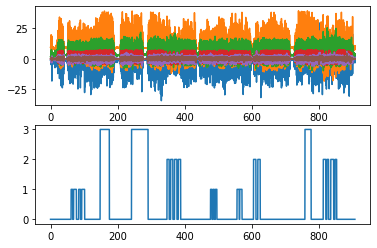

In [ ]:

# pulling data from 
path_to_trainingdata = os.path.abspath(data_folder_path + type_of_data)
subject_001_01__x = os.path.join(path_to_trainingdata,'subject_003_01__x.csv' )
subject_001_01__x_time = os.path.join(path_to_trainingdata, 'subject_003_01__x_time.csv')
subject_001_01__y = os.path.join(path_to_trainingdata,'subject_003_01__y.csv' )
subject_001_01__y_time = os.path.join(path_to_trainingdata,'subject_003_01__y_time.csv' )
# pull data from the file
imu_x = np.genfromtxt(subject_001_01__x,delimiter=',')
imu_y = np.genfromtxt(subject_001_01__y, delimiter='\n')
imu_x_time = np.genfromtxt(subject_001_01__x_time, delimiter='\n')
imu_y_time = np.genfromtxt(subject_001_01__y_time, delimiter='\n')
#create plot
fig, axes = plt.subplots(2, 1)

axes[0].plot(imu_x_time, imu_x)
axes[1].plot(imu_y_time, imu_y)

Trenton's dataset saving code below. Should be able to save mulitple datasets with one fucntion, then in  different notebook load them. This way we can save datasets without having to make them everytime, and we can have multiple models working in parallel on the same dataset. 

In [ ]:
def saveNumpyData(data, data_folder, filename):
  '''Saves a numpy array to file'''
  competition_path = "/content/drive/Shareddrives/Neural Nets/Competition/Phase 1/Data" #path to data folder in drive
  data_file_path = os.path.join(competition_path, data_folder, filename+".npy") #joing path and adding .npy to filename passed in 
  np.save(data_file_path, data) #saves file to specific data path 

def loadNumpyData(data_folder, filename):
  '''Saves a numpy array to file'''
  competition_path = "/content/drive/Shareddrives/Neural Nets/Competition/Phase 1/Data" #path to data folder in drive
  data_file_path = os.path.join(competition_path, data_folder, filename+".npy") #joing path and adding .npy to filename passed in
  return np.load(data_file_path) #loads file from a specific data path 


def saveDataSet(data_set, data_folder, filename):
  '''Saves an object to file, in this case a dataset'''
  competition_path = "/content/drive/Shareddrives/Neural Nets/Competition/Phase 1/Data"  #path to data folder in drive
  data_file_path = os.path.join(competition_path, data_folder, filename+".pt")  #joing path and adding .npy to filename passed in 
  torch.save(data_set, data_file_path) # saves dataset to a file for permanent storage, can be used in other notebooks using load commands below


def loadDataSet(data_folder, filename):
  '''Loads an object from file, in this case a dataset'''
  competition_path = "/content/drive/Shareddrives/Neural Nets/Competition/Phase 1/Data" #path to data folder in drive
  data_file_path = os.path.join(competition_path, data_folder, filename+".pt")  #joing path and adding .npy to filename passed in 
  return torch.load(data_file_path) #returns dataset from filepath/filename 


def saveMulDataSets(data_folder, file_dict):
  '''Place name and data in dictionary for saving mulitple files easily
    Dictionaries key should be the filename you want to save the dataset as
    Dictionaries value should be the datset you want to save
    Ex: model_training_files = {"train_data" : train_data, "valid_train" : valid_data, "test_data":test_data}
  '''
  for filename, dataset in file_dict.items(): #pull filename and dataset in dictionary in "filname" : dataset format 
    print(filename)
    print(dataset)
    saveDataSet(dataset, data_folder, filename) #uses the saveDataSet function above
    pass



def loadMulDataSets(data_folder, filename_list):
  '''Place names of files in a list for loading mulitple files easily
    filename_list should be the filenames you want to load the dataset from
    data_folder is the folder inside "Data" you want to load data from
    '''
  list_of_datasets = []
  for filename in filename_list:
    list_of_datasets.append(loadDataSet(data_folder, filename))
  return list_of_datasets


CODE FROM HOMEWORK 5 FOR TESTING

In [ ]:
import os
import torch
import pandas as pd
from torchvision.io import read_image
import torch
from torch.utils.data import Dataset
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt
import torchvision.transforms as transforms

class CustomImageDataset(Dataset):
    def __init__(self, x_data, y_data, img_dir=None, transform=None, target_transform=None):
        self.img_labels = y_data
        self.img_dir = img_dir
        self.x_data = x_data
        self.y_data = y_data
        self.transform = transform
        self.target_transform = target_transform

    def __len__(self):
        return len(self.img_labels)

    def __getitem__(self, idx):
        image = self.x_data[idx]
        label = self.y_data[idx]
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            label = self.target_transform(label)
        return image, label


our_transform = transforms.Compose([
    # Converting RGB [0,255] to Tensor [0,1]
    transforms.ToTensor(),
    ])

batch_size = 20;

num_sets = 100

# TODO ADD SEED TO createNewSubSet

# Trenton's helper code for gettting random samples from our sets 
def createNewSubSet(num_set, main_set_x, main_set_y):
  subset_x = []
  subset_y = []
  for i in range(num_set): # Loop over the number of train sets
      index_to_add = random.randrange(0, len(main_set_x), 1) # Find a random index to remove
      subset_x.append(main_set_x[index_to_add]) # Append the set to training_sets
      subset_y.append(main_set_y[index_to_add])
  return np.asarray(subset_x), np.asarray(subset_y)


# could grab balanced set 

def getMaxNumberSampleToTrainOn(main_x_image_stack, main_y_label_stack):
  ''' This function probably only needs indices length path into min'''
  zeros_indices = np.where(main_y_label_stack == 0)
  ones_indices = np.where(main_y_label_stack == 1)
  twos_indices = np.where(main_y_label_stack == 2)
  threes_indices = np.where(main_y_label_stack == 3)
  # Seperating out Data 
  zeros_data = np.take(main_x_image_stack,zeros_indices, axis=0)
  zeros_labels = np.take(main_y_label_stack, zeros_indices, axis=0)
  
  ones_data = np.take(main_x_image_stack,ones_indices, axis=0)
  ones_labels= np.take(main_y_label_stack, ones_indices, axis=0)

  twos_data = np.take(main_x_image_stack, twos_indices, axis=0)
  twos_labels= np.take(main_y_label_stack, twos_indices, axis=0)

  
  threes_data = np.take(main_x_image_stack, threes_indices, axis=0)
  threes_labels= np.take(main_y_label_stack, threes_indices, axis=0)

  # Shuffle Each one for easier data splitting 
  np.random.shuffle(zeros_data)
  np.random.shuffle(ones_data)
  np.random.shuffle(twos_data)
  np.random.shuffle(threes_data)

 

  min_count = min(zeros_data.shape[1], ones_data.shape[1], twos_data.shape[1], threes_data.shape[1])
  return min_count

def createBalancedImageStackes(main_x_image_stack, main_y_label_stack, train_percent, val_percent):
  # Create np array of all images sandiwched wiht respective label 
  # Seperate out differnet 0s, 1s, 2s, and 3s
  # Just increment over?
  # Would like to just add to the 6s values
  zeros_indices = np.where(main_y_label_stack == 0)
  ones_indices = np.where(main_y_label_stack == 1)
  twos_indices = np.where(main_y_label_stack == 2)
  threes_indices = np.where(main_y_label_stack == 3)
  # Seperating out Data 
  zeros_data = np.take(main_x_image_stack,zeros_indices, axis=0)[0]
  zeros_labels = np.take(main_y_label_stack, zeros_indices, axis=0)[0]
  
  
  ones_data = np.take(main_x_image_stack,ones_indices, axis=0)[0]
  ones_labels= np.take(main_y_label_stack, ones_indices, axis=0)[0]

  twos_data = np.take(main_x_image_stack, twos_indices, axis=0)[0]
  twos_labels= np.take(main_y_label_stack, twos_indices, axis=0)[0]

  
  threes_data = np.take(main_x_image_stack, threes_indices, axis=0)[0]
  threes_labels= np.take(main_y_label_stack, threes_indices, axis=0)[0]
   

  print("Zeros Data Shape: ", zeros_data.shape)
  # Shuffle Each one for easier data splitting 
  np.random.shuffle(zeros_data) 
  np.random.shuffle(ones_data)
  np.random.shuffle(twos_data)
  np.random.shuffle(threes_data)

  assert np.sum(zeros_labels) == 0
  assert np.sum(ones_labels) == ones_data.shape[0]
  assert np.sum(twos_labels) == twos_data.shape[0] * 2
  assert np.sum(threes_labels) == threes_data.shape[0] * 3  # all labels are most likely threes 
  data_list = [zeros_data.shape[0], ones_data.shape[0], twos_data.shape[0], threes_data.shape[0]]
  min_count = min(data_list)
  number_causing_min = data_list.index(min_count)
  print("Max We Can Process based on Number: ", min_count)
  print("Number with Min Samples :", number_causing_min)


  train_count_per_number = math.floor(min_count * train_percent * .25/100) # if min is 1000 (say 1000 1s), gets (1000 * .6 /100) then splits it into quaters with .25 to get the amount we want to pull per number
  val_count_per_number = math.floor(min_count * val_percent*.25/100)
  test_count_per_number = math.floor(min_count * (100 - val_percent- train_percent) *.25/100)

  print("Total Training Amount: ", train_count_per_number * 4)
  print("Total Validation Amount: ", val_count_per_number * 4)
  print("Total Testing Amount: ", test_count_per_number * 4)

 


  train_index = train_count_per_number
  val_index = train_count_per_number + val_count_per_number
  test_index = train_count_per_number + val_count_per_number + test_count_per_number

  print("Train Index: ", train_index)
  print("Val Index: ", val_index)
  print("Test Index: ", test_index)


  x_train_zeros = zeros_data[:train_index] # note these data values are shuffled 
  x_val_zeros = zeros_data[train_index:val_index]
  x_test_zeros = zeros_data[val_index:test_index]
  y_train_zeros = zeros_labels[:train_index]
  y_val_zeros = zeros_labels[train_index:val_index]
  y_test_zeros = zeros_labels[val_index:test_index]
  
  x_train_ones = ones_data[:train_index]
  x_val_ones = ones_data[train_index:val_index]
  x_test_ones = ones_data[val_index:test_index]
  y_train_ones = ones_labels[:train_index]
  y_val_ones = ones_labels[train_index:val_index]
  y_test_ones = ones_labels[val_index:test_index]
  
  x_train_twos = twos_data[:train_index]
  x_val_twos = twos_data[train_index:val_index]
  x_test_twos = twos_data[val_index:test_index]
  y_train_twos = twos_labels[:train_index]
  y_val_twos = twos_labels[train_index:val_index]
  y_test_twos = twos_labels[val_index:test_index]
  
  
  x_train_threes = threes_data[:train_index]
  x_val_threes = threes_data[train_index:val_index]
  x_test_threes = threes_data[val_index:test_index]
  y_train_threes = threes_labels[:train_index]
  y_val_threes = threes_labels[train_index:val_index]
  y_test_threes = threes_labels[val_index:test_index]
  
  print("X_Train_Zeros Shape: ",x_train_zeros.shape)
  print("X_Train_Ones Shape: ",x_train_ones.shape)
  print("X_Train_Twos Shape: ",x_train_twos.shape)
  print("X_Train_Threes Shape: ",x_train_threes.shape)

  print("Y_Train_Zeros Shape: ",y_train_zeros.shape)
  print("Y_Train_Ones Shape: ",y_train_ones.shape)
  print("Y_Train_Twos Shape: ",y_train_twos.shape)
  print("Y_Train_Threes Shape: ",y_train_threes.shape)

  
  print("X_Test_Zeros Shape: ",x_test_zeros.shape)
  print("X_Test_Ones Shape: ",x_test_ones.shape)
  print("X_Test_Twos Shape: ",x_test_twos.shape)
  print("X_Test_Twos Shape: ",x_test_threes.shape)


  print("Y_Test_Zeros Shape: ",y_test_zeros.shape)
  print("Y_Test_Ones Shape: ",y_test_ones.shape)
  print("Y_Test_Twos Shape: ",y_test_twos.shape)
  print("Y_Test_Twos Shape: ",y_test_threes.shape)


  balance_train_x = np.concatenate((x_train_zeros, x_train_ones, x_train_twos, x_train_threes), axis = 0) #note this has 0s then 1s then 2s then 3s, so it needs to be shuffled later on, but not sure how to do that with ys too, I have been relying on the data loader to pull them out
  balance_train_y = np.concatenate((y_train_zeros, y_train_ones, y_train_twos, y_train_threes), axis = 0)
  
  balance_val_x = np.concatenate((x_val_zeros, x_val_ones, x_val_twos, x_val_threes),axis = 0)
  balance_val_y = np.concatenate((y_val_zeros, y_val_ones, y_val_twos, y_val_threes),axis = 0)

  balance_test_x = np.concatenate((x_test_zeros, x_test_ones, x_test_twos, x_test_threes), axis = 0)
  balance_test_y = np.concatenate((y_test_zeros, y_test_ones, y_test_twos, y_test_threes), axis = 0)

  # Need to make sure these numbers make sense 
  print("Balance_Train_X Shape: ", balance_train_x.shape)
  print("Data Input Shape: ", main_x_image_stack.shape)
  print("Sume of Labels: ", np.sum(balance_train_y))

  return balance_train_x, balance_train_y, balance_val_x, balance_val_y, balance_test_x, balance_test_y
  
  # build each set 
  

  



# this is a bandaid for now



x_train_len = 1200 * 2 *4
x_val_len = 400 * 2 * 4
x_test_len = 400 * 2 * 4

x_image_stack = np.concatenate((x_train, x_val, x_test))
y_image_stack = np.concatenate((y_train, y_val, y_test))

print("x_image_stack shape: ", x_image_stack.shape)
print("y_image_stack shape: ", y_image_stack.shape)
max = getMaxNumberSampleToTrainOn(x_image_stack, y_image_stack)

print("Max Number You can Train on: " , max)



if BALANCED:
  x_train_bal, y_train_bal, x_val_bal, y_val_bal, x_test_bal, y_test_bal = createBalancedImageStackes(x_image_stack,y_image_stack, 60, 20 )
  if(SMALL):
    small_x_train, small_y_train = createNewSubSet(min(x_train_len],x_train_bal.shape[0]) , x_train_bal, y_train_bal)
    small_x_val, small_y_val = createNewSubSet(min(x_val_len],x_val_bal.shape[0]), x_val_bal, y_val_bal)
    small_x_test, small_y_test = createNewSubSet(min(x_test_len],x_test_bal.shape[0]), y_test_bal)
    print("SMALL")
  else:

  print("BALANCED")
else:
  small_x_train, small_y_train = createNewSubSet(x_train_len, x_train, y_train)
  small_x_val, small_y_val = createNewSubSet(x_val_len, x_val, y_val)
  small_x_test, small_y_test = createNewSubSet(x_test_len, x_test, y_test)


list_train = []
list_val = []
sum_list_train = []
sum_list_val = []
sum_list_test = []


for image in small_x_train:
  #print(image)
  list_train.append(image)
  sum_list_train.append(np.sum(image))
for image in small_x_val:
  list_val.append(image)
  sum_list_val.append(np.sum(image))
for image in small_x_test:
  sum_list_test.append(np.sum(image))
  




#intersect = np.in1d(array_train, array_val)


# for datapoint in x_train:
#   for datapoint2 in x_val:
#     if(np.array_equal(datapoint, datapoint2)):
#       overlap = overlap + 1
#       print("Overlap!")
# print(overlap)



# x_train_re = np.reshape(x_train, [x_train.shape[0], 6, 60, 1])
# #y_train = np.reshape(y_train, [y_train.shape[0], 1, 60, 6])
# x_val_re = np.reshape(x_val, [x_val.shape[0], 6, 60, 1])
# #y_val = np.reshape(y_val, [y_val.shape[0], 1, 60, 6])
# x_test_re = np.reshape(x_test, [x_test.shape[0], 6, 60, 1])
# #y_test = np.reshape(y_test, [y_test.shape[0], 1, 60, 6])

# y_train_t = torch.tensor(y_train).type(torch.LongTensor) 
# y_val_t = torch.tensor(y_val).type(torch.LongTensor) 
# y_test_t = torch.tensor(y_test).type(torch.LongTensor) 


x_train_re = np.reshape(small_x_train, [small_x_train.shape[0], 6, 60, 1])
#y_train = np.reshape(y_train, [y_train.shape[0], 1, 60, 6])
x_val_re = np.reshape(small_x_val, [small_x_val.shape[0], 6, 60, 1])
#y_val = np.reshape(y_val, [y_val.shape[0], 1, 60, 6])
x_test_re = np.reshape(small_x_test, [small_x_test.shape[0], 6, 60, 1])
#y_test = np.reshape(y_test, [y_test.shape[0], 1, 60, 6])

y_train_t = torch.tensor(small_y_train).type(torch.LongTensor) 
y_val_t = torch.tensor(small_y_val).type(torch.LongTensor) 
y_test_t = torch.tensor(small_y_test).type(torch.LongTensor) 


train_data = CustomImageDataset(x_train_re, y_train_t, transform=our_transform)
valid_data = CustomImageDataset(x_val_re, y_val_t, transform=our_transform)
test_data = CustomImageDataset(x_test_re, y_test_t, transform=our_transform)

print("Test Data Shape: ", test_data.x_data.shape)


################ Saving Data to a File #####################
model_training_files = {"train_data" : train_data, "valid_train" : valid_data, "test_data":test_data} #creating dictionary giving each dataset a filename 

if BALANCED:
  saveMulDataSets("Balanced", model_training_files) # saving our datasets to files 
else:
  saveMulDataSets("1", model_training_files) # saving our datasets to files

############### Loading Data from a File ###################
list_datasets = loadMulDataSets("1", model_training_files) #loading data set for proof of concept 

print(list_datasets)




x_image_stack shape:  (35200, 60, 6)
y_image_stack shape:  (35200,)
Max Number You can Train on:  2608
Zeros Data Shape:  (23915, 60, 6)
Max We Can Process based on Number:  2608
Number with Min Samples : 1
Total Training Amount:  1564
Total Validation Amount:  520
Total Testing Amount:  520
Train Index:  391
Val Index:  521
Test Index:  651
X_Train_Zeros Shape:  (391, 60, 6)
X_Train_Ones Shape:  (391, 60, 6)
X_Train_Twos Shape:  (391, 60, 6)
X_Train_Threes Shape:  (391, 60, 6)
Y_Train_Zeros Shape:  (391,)
Y_Train_Ones Shape:  (391,)
Y_Train_Twos Shape:  (391,)
Y_Train_Threes Shape:  (391,)
X_Test_Zeros Shape:  (130, 60, 6)
X_Test_Ones Shape:  (130, 60, 6)
X_Test_Twos Shape:  (130, 60, 6)
X_Test_Twos Shape:  (130, 60, 6)
Y_Test_Zeros Shape:  (130,)
Y_Test_Ones Shape:  (130,)
Y_Test_Twos Shape:  (130,)
Y_Test_Twos Shape:  (130,)
Balance_Train_X Shape:  (1564, 60, 6)
Data Input Shape:  (35200, 60, 6)
Sume of Labels:  2346.0
BALANCED
Test Data Shape:  (520, 6, 60, 1)
train_data
valid_trai

In [ ]:
sum_train_np = np.asarray(sum_list_train)
sum_val_np = np.asarray(sum_list_val)
sum_test_np = np.asarray(sum_list_test)

intersect_train_val = np.isin(sum_train_np, sum_val_np)
intersect_val_test = np.isin(sum_val_np, sum_test_np)
intersect_train_test = np.isin(sum_train_np, sum_test_np)


In [ ]:
print("Train and Val Intersection: ", np.sum(intersect_train_val))
print("Val and Test Intersection: ", np.sum(intersect_val_test))
print("Train and Test: ", np.sum(intersect_train_test))


Train and Val Intersection:  0
Val and Test Intersection:  0
Train and Test:  0


In [ ]:
if BALANCED:
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size, shuffle=True)
  valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size, shuffle=True, )
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size, shuffle=True, )
  print("BALANCED")

else:
  train_loader = torch.utils.data.DataLoader(train_data, batch_size=batch_size)
  valid_loader = torch.utils.data.DataLoader(valid_data, batch_size=batch_size)
  test_loader = torch.utils.data.DataLoader(test_data, batch_size=batch_size)


_iter = iter(train_loader)
print(type(_iter))
image_batch, index = next(_iter)
print(image_batch.shape)

print("Train Loader X Shape: ", train_loader.dataset.x_data.shape)
print("Val Loader X Shape: ", valid_loader.dataset.x_data.shape)
print("Test Loader X Shape: ", test_loader.dataset.x_data.shape)




BALANCED
<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
torch.Size([20, 1, 6, 60])
Train Loader X Shape:  (1564, 6, 60, 1)
Val Loader X Shape:  (520, 6, 60, 1)
Test Loader X Shape:  (520, 6, 60, 1)


In [ ]:

# Defining the CNN architecture
class Net(nn.Module):
  def __init__(self):
    super(Net, self).__init__()
    self.conv1 = nn.Conv2d(1, 6, 5, padding=2, padding_mode='zeros', dtype=float)
   ## nn.MaxPool2d()
    self.conv2 = nn.Conv2d(6, 16, 5, dtype=float)
    self.fc1 = nn.Linear(16 * 56 * 2, 800, dtype=float)
    self.fc2 = nn.Linear(800, 200, dtype=float) 
    self.fc3 = nn.Linear(200, 50, dtype=float)
    self.fc4 = nn.Linear(50, 4, dtype=float)
  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.relu(self.conv2(x))
    x = x.view(-1, 16 * 56 * 2) # At this point the feature map is 5 x 5 x 16
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = self.fc4(x)
    return x

# Create a complete CNN
model = Net()
print(model)

# Move tensors to GPU if CUDA is available
flag_cuda = torch.cuda.is_available()
if flag_cuda:
  model.cuda()

# Specifying the loss function
criterion = nn.CrossEntropyLoss()

# Specify optimizer
optimizer = optim.Adam(model.parameters(), lr=.0005)




Net(
  (conv1): Conv2d(1, 6, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
  (conv2): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
  (fc1): Linear(in_features=1792, out_features=800, bias=True)
  (fc2): Linear(in_features=800, out_features=200, bias=True)
  (fc3): Linear(in_features=200, out_features=50, bias=True)
  (fc4): Linear(in_features=50, out_features=4, bias=True)
)


Epoch: 1 	Training Loss: 0.176958 	Validation Loss: 0.135615
Validation loss decreased (inf --> 0.135615).  Saving model ...
Epoch: 2 	Training Loss: 0.104541 	Validation Loss: 0.115636
Validation loss decreased (0.135615 --> 0.115636).  Saving model ...
Epoch: 3 	Training Loss: 0.068206 	Validation Loss: 0.086315
Validation loss decreased (0.115636 --> 0.086315).  Saving model ...
Epoch: 4 	Training Loss: 0.041063 	Validation Loss: 0.094204
Epoch: 5 	Training Loss: 0.029877 	Validation Loss: 0.082083
Validation loss decreased (0.086315 --> 0.082083).  Saving model ...
Epoch: 6 	Training Loss: 0.017638 	Validation Loss: 0.087318
Epoch: 7 	Training Loss: 0.008779 	Validation Loss: 0.106596


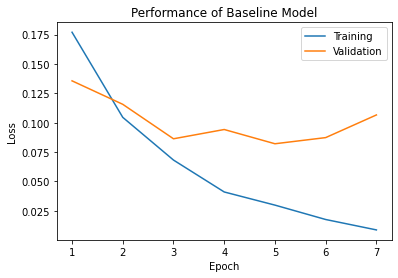

In [ ]:
import matplotlib.pyplot as plt

# Specifying the number of epochs
n_epochs = 7

def trainNet(model,criterion,optimizer,n_epochs,flag_cuda):
  # Unpacking the number of epochs to train the model
  epochs_list = [*range(1,n_epochs+1)]

  # List to store loss to visualize
  train_losslist = []
  valid_losslist = []
  valid_loss_min = np.Inf # track change in validation loss

  for epoch in epochs_list:
      # Keeping track of training and validation loss
      train_loss = 0.0
      valid_loss = 0.0
      
      ######################
      # Training the model #
      ######################
      model.train()
      for data, target in train_loader:
          # Moving tensors to GPU if CUDA is available
          if flag_cuda:
              data, target = data.cuda(), target.cuda()
          # Clearing the gradients of all optimized variables
          optimizer.zero_grad()
          # Forward pass: Computing predicted outputs
          output = model(data)
          # Calculating the batch loss
          loss = criterion(output, target)
          # Backward pass: compute gradient of loss with respect to parameters
          loss.backward()
          # Perform a single optimization step (parameter update)
          optimizer.step()
          # Update training loss
          train_loss += loss.item()*data.size(0)
          
      ########################    
      # Validating the model #
      ########################
      model.eval()
      for data, target in valid_loader:
          # Moving tensors to GPU if CUDA is available
          if flag_cuda:
              data, target = data.cuda(), target.cuda()
          output = model(data)
          loss = criterion(output, target)
          valid_loss += loss.item()*data.size(0)
      
      # Calculating average losses
      train_loss = train_loss/x_train_len
      valid_loss = valid_loss/x_val_len
      train_losslist.append(train_loss)
      valid_losslist.append(valid_loss)
          
      # Printing training/validation statistics 
      print('Epoch: {} \tTraining Loss: {:.6f} \tValidation Loss: {:.6f}'.format(
          epoch, train_loss, valid_loss))
      
      # Saving model if validation loss has decreased
      if valid_loss <= valid_loss_min:
          print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(
              valid_loss_min,valid_loss))
          torch.save(model.state_dict(), 'model_cifar.pt')
          valid_loss_min = valid_loss
        
  return epochs_list, train_losslist, valid_losslist

# Executing the training
epochs_list, train_losslist, valid_losslist = trainNet(
    model,criterion,optimizer,n_epochs,flag_cuda)

# Loading the best model
model.load_state_dict(torch.load('model_cifar.pt'))

# Plotting the learning curves
plt.plot(epochs_list, train_losslist, epochs_list, valid_losslist)
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend(['Training','Validation'])
plt.title("Performance of Baseline Model")
plt.show()

In [ ]:

classes = [0, 1, 2, 3]

def assessNet(model,criterion):
  # Tracking test loss and accuracy
  test_loss = 0.0
  class_correct = list(0. for i in range(len(classes)))
  class_total = list(0. for i in range(len(classes)))

  # Setting model to evaluate
  model.eval()

  # Iterating over batches of test data
  for data, target in test_loader:
      # Obtaining predictions and loss
      if flag_cuda:
          data, target = data.cuda(), target.cuda()
      output = model(data)
      loss = criterion(output, target)
      test_loss += loss.item()*data.size(0)

      # Converting output probabilities to predicted class
      _, pred = torch.max(output, 1)    
      # Comparing predictions to true label
      correct_tensor = pred.eq(target.data.view_as(pred))
      correct = np.squeeze(correct_tensor.numpy()) if not flag_cuda else np.squeeze(correct_tensor.cpu().numpy())
      # Calculating test accuracy for each object class
      for i in range(min(batch_size, target.data.shape[0])):
          label = target.data[i]
          class_correct[label] += correct[i].item()
          class_total[label] += 1

  # Computing the average test loss
  test_loss = test_loss/len(test_loader.dataset)
  print('Test Loss: {:.6f}\n'.format(test_loss))

  # Computing the class accuracies
  for i in range(4):
      if class_total[i] > 0:
          print('Test Accuracy of %10s: %2d%% (%2d/%2d)' % (
              classes[i], 100 * class_correct[i] / class_total[i],
              np.sum(class_correct[i]), np.sum(class_total[i])))
      else:
          print('Test Accuracy of %10s: N/A (no training examples)' % (classes[i]))

  # Computing the overall accuracy
  print('\nTest Accuracy (Overall): %2d%% (%2d/%2d)' % (
      100. * np.sum(class_correct) / np.sum(class_total),
      np.sum(class_correct), np.sum(class_total)))
  
  return

# Executing the assessment
assessNet(model,criterion)

Test Loss: 0.428232

Test Accuracy of          0: 75% (90/119)
Test Accuracy of          1: 95% (118/123)
Test Accuracy of          2: 91% (125/136)
Test Accuracy of          3: 75% (107/142)

Test Accuracy (Overall): 84% (440/520)


In [ ]:
# ^^^^^^ NOT SURE WHY ITS NOT THE SAME ACROSS THE BOARD????